<a href="https://colab.research.google.com/github/Joy201002143/python_projects/blob/main/MADDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/openai/multiagent-particle-envs

Cloning into 'multiagent-particle-envs'...
remote: Enumerating objects: 234, done.
remote: Total 234 (delta 0), reused 0 (delta 0), pack-reused 234
Receiving objects: 100% (234/234), 101.53 KiB | 1.28 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install JSAnimation

  Created wheel for JSAnimation: filename=JSAnimation-0.1-cp37-none-any.whl size=11426 sha256=8a29b1760d76bfba80dda114ed68d80a01409b2b5dafe43c24228bf64d384093
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation


In [ ]:
cd multiagent-particle-envs/

/content/multiagent-particle-envs


In [ ]:
!pip install gym==0.10.5
!pip install pyglet==1.3.2

     |████████████████████████████████| 1.5MB 3.1MB/s 
  Created wheel for gym: filename=gym-0.10.5-cp37-none-any.whl size=1581309 sha256=61bfa258a7da5b761f5f476572f45078218a221c94b10635ed3492611ecf51eb
  Stored in directory: /root/.cache/pip/wheels/cb/14/71/f4ab006b1e6ff75c2b54985c2f98d0644fffe9c1dddc670925
Successfully built gym
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
     |████████████████████████████████| 1.0MB 2.1MB/s 
  Found existing installation: pyglet 1.5.0
    Uninstalling pyglet-1.5.0:
      Successfully uninstalled pyglet-1.5.0


In [ ]:
from make_env import make_env
import numpy as np
import copy
from collections import deque
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

from JSAnimation.IPython_display import display_animation
from IPython.display import HTML
from pyvirtualdisplay import Display
pydisplay = Display(visible=0, size=(400, 300))
pydisplay.start()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
class ReplayBuffer:
    def __init__(self,memory_size=1e+6):
        self.memory = deque([],maxlen=memory_size)
        self.is_gpu = torch.cuda.is_available
        return
    def cache(self,state,next_state,action,reward,done):
        if self.is_gpu:
            state = torch.tensor(state,dtype=torch.float).cuda()
            next_state = torch.tensor(next_state,dtype=torch.float).cuda()
            action = torch.tensor(action,dtype=torch.float).cuda()
            reward = torch.tensor(reward).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state,dtype=torch.float)
            next_state = torch.tensor(next_state,dtype=torch.float)
            action = torch.tensor(action,dtype=torch.float)
            reward = torch.tensor(reward)
            done = torch.tensor([done])
        self.memory.append((state,next_state,action,reward,done))
    def sample(self,batch_size=64):
        batch = random.sample(self.memory,batch_size)
        state,next_state,action,reward,done = map(torch.stack,zip(*batch))
        return state,next_state,action,reward.squeeze(),done.squeeze()

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self,num_state,num_action,hidden_size=64):
        super(PolicyNetwork,self).__init__()
        self.fc1 = nn.Linear(num_state,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,num_action)

    def forward(self,x,index):
        x = x[:,index]
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        action = self.fc3(h)
        return action

In [ ]:
class QNetwork(nn.Module):
    def __init__(self,num_state,num_action,agent_num,hidden_size=64,init_w=3e-3):
        super(QNetwork,self).__init__()
        input_size1 = num_state * agent_num
        input_size2 = hidden_size + num_action * agent_num
        self.fc1 = nn.Linear(input_size1,hidden_size)
        self.fc2 = nn.Linear(input_size2,hidden_size)
        self.fc3 = nn.Linear(hidden_size,1)
        self.fc3.weight.data.uniform_(-init_w, init_w)
        self.fc3.bias.data.uniform_(-init_w, init_w)

    def forward(self,states,actions):
        states = states.view(states.size()[0],-1)
        actions = actions.view(actions.size()[0],-1)
        h = F.relu(self.fc1(states))
        x = torch.cat([h,actions],1)
        h = F.relu(self.fc2(x))
        q = self.fc3(h)
        return q

In [ ]:
class OrnsteinUhlenbeckProcess:
    def __init__(self, theta=0.15, mu=0.0, sigma=0.2, dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.num_steps = 0

        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0
            self.c = sigma
            self.sigma_min = sigma

    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.num_steps) + self.c)
        return sigma

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma() * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.num_steps += 1
        return x

In [ ]:
class MaddpgAgents:
    def __init__(self,observation_space,action_space,num_agent,gamma=0.95,lr=0.01,batch_size=1024,memory_size=int(1e6),tau=0.01,grad_norm_clipping = 0.5):
        self.num_state = observation_space
        self.num_action = action_space
        self.n = num_agent
        self.gamma = gamma
        self.actor_group = [PolicyNetwork(self.num_state,self.num_action).to(device) for _ in range(self.n)]
        self.target_actor_group = copy.deepcopy(self.actor_group)
        self.actor_optimizer_group = [optim.Adam(self.actor_group[i].parameters(),lr=0.001
                                                 ) for i in range(self.n)]
        self.critic_group = [QNetwork(self.num_state,self.num_action,self.n).to(device) for _ in range(self.n)]
        self.target_critic_group = copy.deepcopy(self.critic_group)
        self.critic_optimizer_group = [optim.Adam(self.critic_group[i].parameters(),lr=lr) for i in range(self.n)]
        self.buffer = ReplayBuffer(memory_size=memory_size)
        self.loss_fn = torch.nn.MSELoss()
        self.batch_size = batch_size
        self.is_gpu = torch.cuda.is_available
        self.noise = OrnsteinUhlenbeckProcess(size=self.num_action)
        self.grad_norm_clipping = grad_norm_clipping
        self.tau = tau

    @torch.no_grad()
    def td_targeti(self,reward,state,next_state,done,agent_index):
        next_actions = []
        for i in range(self.n):
            actionsi = torch.tanh(self.target_actor_group[i](state,i))
            actionsi = actionsi[:,np.newaxis,:]
            next_actions.append(actionsi)
        next_actions = torch.cat(next_actions,dim=1)
        next_q = self.target_critic_group[agent_index](next_state,next_actions)
        if self.n != 1:
            reward = reward[:,agent_index]
            done = done[:,agent_index]
        reward = reward[:,np.newaxis]
        done = done[:,np.newaxis]
        done = torch.tensor(done,dtype=torch.int)
        td_targeti = reward + self.gamma * next_q*(1.-done.data)
        return td_targeti.float()

    def update(self):
        for i in range(self.n):
            state,next_state,action,reward,done = self.buffer.sample(self.batch_size)
            td_targeti = self.td_targeti(reward,state,next_state,done,i)
            current_q = self.critic_group[i](state,action)
            critic_loss = self.loss_fn(current_q,td_targeti)
            self.critic_optimizer_group[i].zero_grad()
            critic_loss.backward()
            clip_grad_norm_(self.critic_group[i].parameters(),max_norm=self.grad_norm_clipping)
            self.critic_optimizer_group[i].step()
            ac = action.clone()
            ac_up = self.actor_group[i](state,i)
            ac[:,i,:] = torch.tanh(ac_up)
            pr = -self.critic_group[i](state,ac).mean()
            pg = (ac[:,i,:].pow(2)).mean()
            actor_loss = pr + pg*1e-3
            self.actor_optimizer_group[i].zero_grad()
            clip_grad_norm_(self.actor_group[i].parameters(),max_norm=self.grad_norm_clipping)
            actor_loss.backward()
            self.actor_optimizer_group[i].step()
        for i in range(self.n):
            for target_param, local_param in zip(self.target_actor_group[i].parameters(), self.actor_group[i].parameters()):
                target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
            for target_param, local_param in zip(self.target_critic_group[i].parameters(), self.critic_group[i].parameters()):
                target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

    def get_action(self,state,greedy=False):
        state = torch.tensor(state,dtype=torch.float).cuda()
        state = state[np.newaxis,:,:]
        actions = []
        for i in range(self.n):
            action = torch.tanh(self.actor_group[i](state,index=i))
            if not greedy:
                action += torch.tensor(self.noise.sample(),dtype=torch.float).cuda()
            actions.append(action)
        actions = torch.cat(actions,dim=0)
        return np.clip(actions.detach().cpu().numpy(),-1.0,1.0)

In [ ]:
# 各種設定
num_episode = 20000  # 学習エピソード数（論文では25000になっています）
memory_size = 100000  # replay bufferの大きさ
initial_memory_size = 100000  #最初貯める数
# ログ用の設定
episode_rewards = []
num_average_epidodes = 100

env = make_env('simple_spread')
max_steps = 25  # エピソードの最大ステップ数
agent = MaddpgAgents(18, 5, num_agent=env.n,memory_size=memory_size)

# 最初にreplay bufferにノイズのかかった行動をしたときのデータを入れる
state = env.reset()
for step in range(initial_memory_size):
    if step % max_steps == 0:
        state = env.reset()
    actions = agent.get_action(state)
    next_state, reward, done, _ = env.step(actions)
    agent.buffer.cache(state,next_state,actions,reward,done)
    state = next_state
print('%d Data collected' % (initial_memory_size))

100000 Data collected


Episode 0 finished | Episode reward -908.174468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 20 finished | Episode reward -1240.992517
Episode 40 finished | Episode reward -937.767973
Episode 60 finished | Episode reward -914.444637
Episode 80 finished | Episode reward -1043.960141
Episode 100 finished | Episode reward -1340.936484
Episode 120 finished | Episode reward -1061.875055
Episode 140 finished | Episode reward -2034.430636
Episode 160 finished | Episode reward -1692.425849
Episode 180 finished | Episode reward -931.397297
Episode 200 finished | Episode reward -1348.627557
Episode 220 finished | Episode reward -1052.438426
Episode 240 finished | Episode reward -862.040023
Episode 260 finished | Episode reward -1184.886465
Episode 280 finished | Episode reward -746.891847
Episode 300 finished | Episode reward -1626.721808
Episode 320 finished | Episode reward -838.034598
Episode 340 finished | Episode reward -866.938928
Episode 360 finished | Episode reward -1293.642124
Episode 380 finished | Episode reward -973.195083
Episode 400 finished | Episode reward -763.

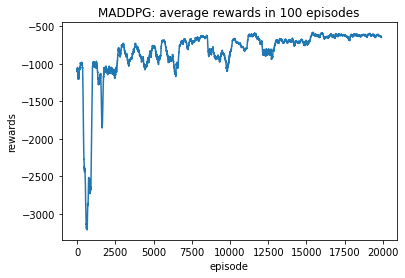

In [ ]:
for episode in range(num_episode):
    state = env.reset()
    episode_reward = 0
    for t in range(max_steps):
        actions = agent.get_action(state)
        next_state, reward, done, _ = env.step(actions)
        episode_reward += sum(reward)
        agent.buffer.cache(state,next_state,actions,reward,done)
        state = next_state
        if all(done):
            break
    if episode % 4 == 0:
        agent.update()
    episode_rewards.append(episode_reward)
    if episode % 20 == 0:
        print("Episode %d finished | Episode reward %f" % (episode, episode_reward))

# 累積報酬の移動平均を表示
moving_average = np.convolve(episode_rewards, np.ones(num_average_epidodes)/num_average_epidodes, mode='valid')
plt.plot(np.arange(len(moving_average)),moving_average)
plt.title('MADDPG: average rewards in %d episodes' % num_average_epidodes)
plt.xlabel('episode')
plt.ylabel('rewards')
plt.show()

env.close()

In [ ]:
state = env.reset()
episode_reward = 0
#frames = []
#env.render()
#screen = env.render(mode='rgb_array')
#frames.append(screen[0])
for t in range(max_steps):
    actions = agent.get_action(state,greedy=True)
    next_state, reward, done, _ = env.step(actions)
    episode_reward += sum(reward)
    #agent.buffer.cache(state,next_state,actions,reward,done)
    #env.render()
    #screen = env.render(mode='rgb_array')
    #frames.append(screen[0])
    state = next_state
print(episode_reward)

-615.0659957903836


In [ ]:
# 結果の確認
plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
HTML(anim.to_jshtml())